In [13]:
using DifferentialEquations, LinearAlgebra
using Statistics, Folds
using Plots, LaTeXStrings
using JLD2

TWA

In [57]:
function sampleSpinZPlus()
    θ = acos(1/sqrt(3))
    ϕ = 2π * rand()
    return θ, ϕ
end

function sampleSpinZMinus()
    θ = π - acos(1/sqrt(3))
    ϕ = 2π * rand()
    return θ, ϕ
end

function sampleFullyMixed()
    θ = π * rand()
    ϕ = 2π * rand()
    return θ, ϕ
end

sampleFullyMixed (generic function with 1 method)

In [58]:
#The purpose of this section is to set up the initial spin configuration, 
#which is essential for correctly simulating the time evolution of the spin 
#system using the TWA method.
sx = 0.
sy = 0.
sz = 0.
nTraj = 10000
#sx, sy, sz: These variables will store the accumulated 
#values of the spin components
for n = 1:nTraj
    θ, ϕ = sampleSpinZPlus()
    sx += sqrt(3) * sin(θ) * cos(ϕ)
    sy += sqrt(3) * sin(θ) * sin(ϕ)
    sz += sqrt(3) * cos(θ)
end
#computes the average spin components 
#by dividing by the number of trajectories
sx /= nTraj
sy /= nTraj
sz /= nTraj

1.0

In [59]:
#the code defines how to set up the initial conditions for the system's 
#stochastic evolution. The goal is to simulate an ensemble of trajectories 
#of the system, each starting with a slightly different initial condition 
#sampled from a specific distribution, and then evolve these trajectories 
#using stochastic differential equations (SDEs).
function prob_func(prob, i, repeat)
    #The function prob_func is used to generate different initial 
    #conditions for each trajectory in the ensemble.
    u0 = Vector{Float64}(undef, 2)
    θn, ϕn = sampleSpinZMinus()
    u0[1] = θn
    u0[2] = ϕn
    #The function remake(prob, u0=u0) creates a modified version 
    #of the SDE problem (prob) with the new initial condition u0.
    
    #This allows each trajectory in the ensemble to start from a 
    #different initial condition.
    remake(prob, u0=u0)
end

function drift!(du, u, p, t)
    # drift = deterministic change ~dt
    Γ, Ω, Δ = p
    θ = u[1]
    ϕ = u[2]
    
    du[1] = Γ * (cot(θ) + csc(θ) / sqrt(3)) + 2* Ω * sin(ϕ) # dθ = ... dt
    du[2] = 2 * Ω * cot(θ) * cos(ϕ) - Δ #dϕ = ... dt
    nothing
end

function diffusion!(du, u, p, t)
    # diffusion = stochastic change ~dW
    Γ, Ω, Δ = p
    θ = u[1]
    ϕ = u[2]
    dΓ = sqrt(Γ) * sqrt(1 + 2 * cot(θ)^2 + 2 * cot(θ) * csc(θ) / sqrt(3))
    du[1] = 0. # dθ = ... dW_1
    du[2] = dΓ # dϕ = ... dW_2
    nothing
end

diffusion! (generic function with 1 method)

In [60]:
function computeTWA(Ω, Δ, tf, nT, dt, nTraj, p, tspan, t)
    u0 = zeros(2)
    prob = SDEProblem(drift!, diffusion!, u0, tspan, p)
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    
    alg = EM()
    
    sol = solve(ensemble_prob, alg, EnsembleThreads();
        saveat=t, trajectories=nTraj, maxiters=1e+7,
        dt=dt)
    return t, sol
end

computeTWA (generic function with 1 method)

In [119]:
Ω = 1
Δ = 0
Γ = 1
tf = 10
nT = 400
nTraj = 20000
dt = 1e-3
p = Γ, Ω, Δ

(1, 1, 0)

In [ ]:
tspan = (0., tf)
t = LinRange(0., tf, nT)
@time t, sol = computeTWA(Ω, Δ, tf, nT, dt, nTraj, p, tspan, t);

In [81]:
θ = sol[1, :, :]
ϕ = sol[2, :, :]
sx = sqrt(3) * mean(sin.(θ) .* cos.(ϕ), dims=2)[:, 1];
sy = sqrt(3) * mean(sin.(θ) .* sin.(ϕ), dims=2)[:, 1];
sz = sqrt(3) * mean(cos.(θ), dims=2)[:, 1];

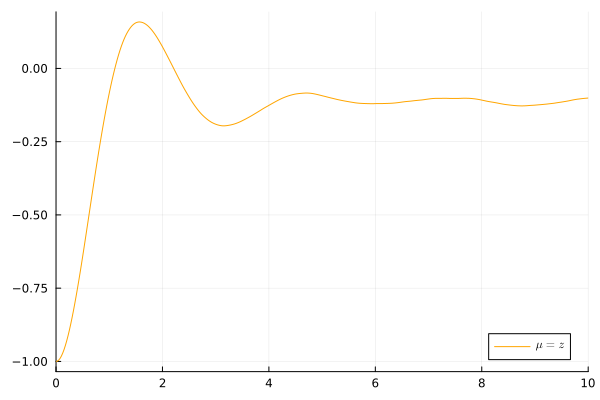

In [82]:
plot(t, sz, label=L"\mu = z", xlim=(0.0,10), color=:orange)
# @save "singleatomsTWA.jld2" sx sy sz

Direct Calculation

In [120]:
function sigmaz_exp!(du, u, p, t)
    ρ_gg, ρ_ge, ρ_eg, ρ_ee = u
    Γ, Ω, Δ = p
    du[1] = Γ * ρ_ee - im * (Ω) * (ρ_ge - ρ_eg)           # dρ_gg
    du[2] = (im * Δ - Γ/2) * ρ_ge + im * (Ω) * (ρ_ee - ρ_gg)      # dρ_ge
    du[3] = -du[2]                                          # dρ_eg
    du[4] = -du[1]                                          # dρ_ee
end

sigmaz_exp! (generic function with 1 method)

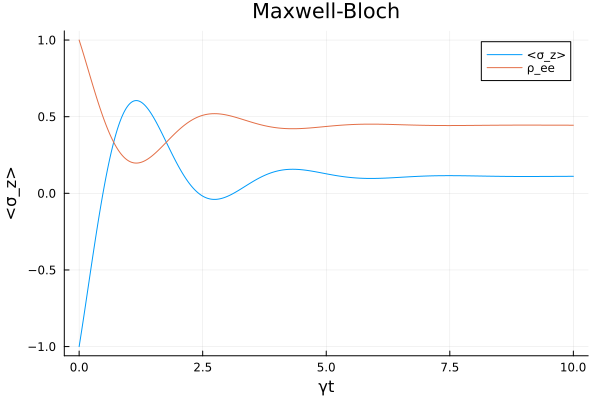

In [121]:
u0 = [0.0, 0.0 + 0.0im, 0.0 + 0.0im, 1.0]

t_steps = range(0.0, stop=tf, length=nT)

prob = ODEProblem(sigmaz_exp!, u0, tspan, p)

sol = solve(prob, Tsit5(), saveat=t_steps)

sigma_z = real(sol[1, :]) - real(sol[4, :])

t = sol.t * Γ
plot(t, sigma_z, label = "<σ_z>", xlabel = "γt", ylabel = "<σ_z>", title = "Maxwell-Bloch")
# plot!(t, ρ_gg_real, label = "ρ_gg")
plot!(t, ρ_ee_real, label = "ρ_ee")
